# Notebook for alignment analysis

Imports

In [ ]:
import time
import os
import importlib

from pprint import pprint
from collections import defaultdict
from pathlib import Path
from more_itertools import grouper
from itertools import islice, chain, zip_longest, repeat

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.axes as ax
import seaborn as sns

import scipy
from scipy import io
from scipy.signal import convolve
from scipy.sparse import coo_matrix, csr_matrix
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import cut_tree

from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

from Modules import utils, plot_utils

Useful global variables

In [ ]:
importlib.reload(utils)
data_dir = '../shared_folder'
writing_dir = '../shared_folder'
# writing_dir='../'
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

Name of chromosomes in GRCh38 and T2T-CHM13v2.0

In [ ]:
hg38_chr_names = {
    1: 'NC_000001.11',
    2: 'NC_000002.12',
    3: 'NC_000003.12',
    4: 'NC_000004.12',
    5: 'NC_000005.10',
    6: 'NC_000006.12',
    7: 'NC_000007.14',
    8: 'NC_000008.11',
    9: 'NC_000009.12',
    10: 'NC_000010.11',
    11: 'NC_000011.10',
    12: 'NC_000012.12',
    13: 'NC_000013.11',
    14: 'NC_000014.9',
    15: 'NC_000015.10',
    16: 'NC_000016.10',
    17: 'NC_000017.11',
    18: 'NC_000018.10',
    19: 'NC_000019.10',
    20: 'NC_000020.11',
    21: 'NC_000021.9',
    22: 'NC_000022.11',
    'X': 'NC_000023.11',
    'Y': 'NC_000024.10',}
T2T_chr_ids = {
    1: 'NC_060925.1',
    2: 'NC_060926.1',
    3: 'NC_060927.1',
    4: 'NC_060928.1',
    5: 'NC_060929.1',
    6: 'NC_060930.1',
    7: 'NC_060931.1',
    8: 'NC_060932.1',
    9: 'NC_060933.1',
    10: 'NC_060934.1',
    11: 'NC_060935.1',
    12: 'NC_060936.1',
    13: 'NC_060937.1',
    14: 'NC_060938.1',
    15: 'NC_060939.1',
    16: 'NC_060940.1',
    17: 'NC_060941.1',
    18: 'NC_060942.1',
    19: 'NC_060943.1',
    20: 'NC_060944.1',
    21: 'NC_060945.1',
    22: 'NC_060946.1',
    'X': 'NC_060947.1',
    'Y': 'NC_060948.1',}
# {"NC_060925.1":"1", "NC_060926.1":"2", "NC_060927.1":"3", "NC_060928.1":"4", "NC_060929.1":"5", "NC_060930.1":"6", "NC_060931.1":"7", "NC_060932.1":"8", "NC_060933.1":"9", "NC_060934.1":"10", "NC_060935.1":"11", "NC_060936.1":"12", "NC_060937.1":"13", "NC_060938.1":"14", "NC_060939.1":"15", "NC_060940.1":"16", "NC_060941.1":"17", "NC_060942.1":"18", "NC_060943.1":"19", "NC_060944.1":"20", "NC_060945.1":"21", "NC_060946.1":"22", "NC_060947.1":"X", "NC_060948.1":"Y"}

Parse sam files and save in npz format

In [ ]:
importlib.reload(utils)
data = 'Judith-H3K27me3'
# ip_coord = utils.parse_sam(f'{data_dir}/{data}/raw_data/IP/D1145C41_trimmed_paired.sam')
ctrl_coord = utils.parse_sam(f'{data_dir}/{data}/raw_data/Control/D1145C46_trimmed_paired.sam')

# if not Path(data_dir, data, 'results', f'{data}_IP_coord_all_chr.npz').is_file():
#     np.savez_compressed(Path(data_dir, data, 'results', f'{data}_IP_coord_all_chr'),
#                         **ip_coord)
if not Path(data_dir, data, 'results', f'{data}_Control_coord_all_chr.npz').is_file():
    np.savez_compressed(Path(data_dir, data, 'results', f'{data}_Control_coord_all_chr'),
                        **ctrl_coord)

54717931/105167322 paired reads rejected


Load npz format

In [ ]:
data = 'Judith-H3K9me3'
chr_id = 1
with np.load(Path(data_dir, data, 'results', f'{data}_IP_coord_all_chr.npz')) as f:
    ip_coord_chr = f[hg38_chr_names[chr_id]]
with np.load(Path(data_dir, data, 'results', f'{data}_Control_coord_all_chr.npz')) as f:
    ctrl_coord_chr = f[hg38_chr_names[chr_id]]
data2 = 'Judith-H3K4me3'
with np.load(Path(data_dir, data2, 'results', f'{data2}_IP_coord_all_chr.npz')) as f:
    ip2_coord_chr = f[hg38_chr_names[chr_id]]
with np.load(Path(data_dir, data2, 'results', f'{data2}_Control_coord_all_chr.npz')) as f:
    ctrl2_coord_chr = f[hg38_chr_names[chr_id]]
data3 = 'Judith-H3K27me3'
with np.load(Path(data_dir, data3, 'results', f'{data3}_Control_coord_all_chr.npz')) as f:
    ctrl3_coord_chr = f[hg38_chr_names[chr_id]]
    # for key in f.keys():
    #     print(key)

Plot lengths

In [ ]:
ip_lengths_chr = np.diff(ip_coord_chr, axis=1).ravel()
ctrl_lengths_chr = np.diff(ctrl_coord_chr, axis=1).ravel()
ip2_lengths_chr = np.diff(ip2_coord_chr, axis=1).ravel()
ctrl2_lengths_chr = np.diff(ctrl2_coord_chr, axis=1).ravel()
ctrl3_lengths_chr = np.diff(ctrl3_coord_chr, axis=1).ravel()

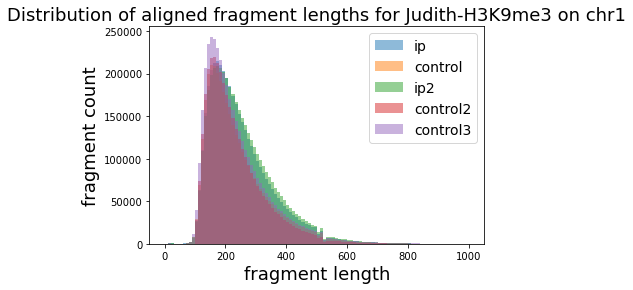

In [ ]:
plt.hist(ip_lengths_chr, bins=100, range=(0, 1000), label='ip', alpha=0.5)
plt.hist(ctrl_lengths_chr, bins=100, range=(0, 1000), label='control', alpha=0.5)
plt.hist(ip2_lengths_chr, bins=100, range=(0, 1000), label='ip2', alpha=0.5)
plt.hist(ctrl2_lengths_chr, bins=100, range=(0, 1000), label='control2', alpha=0.5)
plt.hist(ctrl3_lengths_chr, bins=100, range=(0, 1000), label='control3', alpha=0.5)
plt.legend(fontsize=14)
plt.title(f'Distribution of aligned fragment lengths for {data} on chr{chr_id}', fontsize=18)
plt.xlabel('fragment length', fontsize=18)
plt.ylabel('fragment count', fontsize=18)
plt.savefig(f'{data_dir}/{data}/results/{data}_fragment_length_distribution_chr{chr_id}.png', bbox_inches='tight')
plt.show()
plt.close()

Filter ou long fragments

In [ ]:
# filter out long fragments
threshold = 1000
print(np.sum(ip_lengths_chr >= threshold), f'fragments longer than {threshold}bp in IP')
ip_coord_chr = ip_coord_chr[ip_lengths_chr <= threshold, :]
print(np.sum(ctrl_lengths_chr >= threshold), f'fragments longer than {threshold}bp in Control')
ctrl_coord_chr = ctrl_coord_chr[ctrl_lengths_chr <= threshold, :]

print(np.sum(ip2_lengths_chr >= threshold), f'fragments longer than {threshold}bp in IP2')
ip2_coord_chr = ip2_coord_chr[ip2_lengths_chr <= threshold, :]
print(np.sum(ctrl2_lengths_chr >= threshold), f'fragments longer than {threshold}bp in Control2')
ctrl2_coord_chr = ctrl2_coord_chr[ctrl2_lengths_chr <= threshold, :]

print(np.sum(ctrl3_lengths_chr >= threshold), f'fragments longer than {threshold}bp in Control3')
ctrl3_coord_chr = ctrl3_coord_chr[ctrl3_lengths_chr <= threshold, :]

485 fragments longer than 1000bp in IP
572 fragments longer than 1000bp in Control
638 fragments longer than 1000bp in IP2
391 fragments longer than 1000bp in Control2
613 fragments longer than 1000bp in Control3


#### Binned middle alignment

In [ ]:
bins = 1000
ip_binned_signal_chr = utils.binned_alignment_signal_from_coord(ip_coord_chr, bins=bins)
ctrl_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl_coord_chr, bins=bins)
print(len(ip_binned_signal_chr), len(ctrl_binned_signal_chr))

ip2_binned_signal_chr = utils.binned_alignment_signal_from_coord(ip2_coord_chr, bins=bins)
ctrl2_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl2_coord_chr, bins=bins)
print(len(ip2_binned_signal_chr), len(ctrl2_binned_signal_chr))

ctrl3_binned_signal_chr = utils.binned_alignment_signal_from_coord(ctrl3_coord_chr, bins=bins)
print(len(ctrl3_binned_signal_chr))

248947 248947
248947 248947
248947


Plot of raw signal

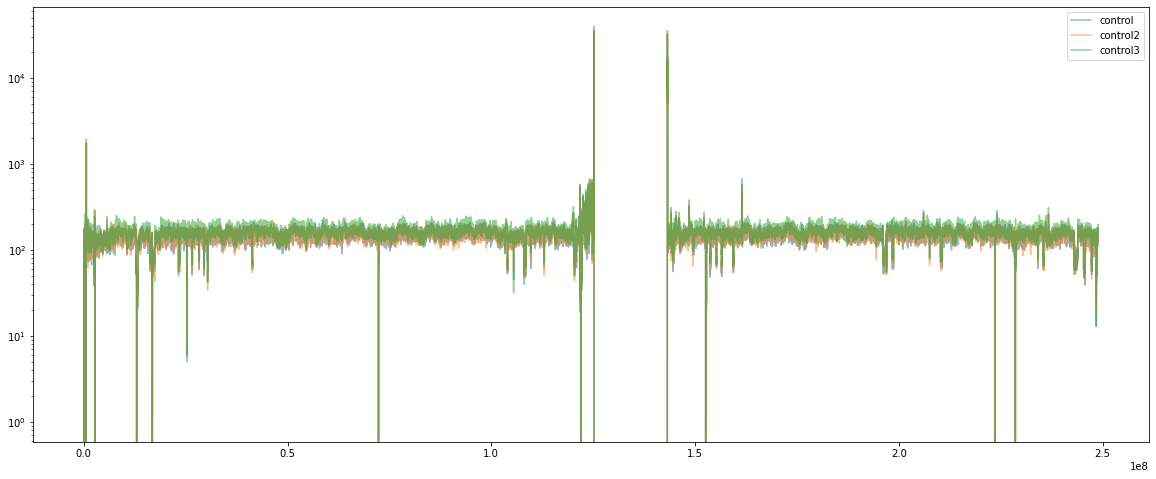

In [ ]:
start = 0  # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
# plt.plot(np.arange(bin_start, bin_end, bins), ip_binned_signal_chr[start//bins:end//bins], label='ip', alpha=0.5)
plt.plot(np.arange(bin_start, bin_end, bins), ctrl_binned_signal_chr[start//bins:end//bins], label='control', alpha=0.5)
# plt.plot(np.arange(bin_start, bin_end, bins), ip2_binned_signal_chr[start//bins:end//bins], label='ip2', alpha=0.5)
plt.plot(np.arange(bin_start, bin_end, bins), ctrl2_binned_signal_chr[start//bins:end//bins], label='control2', alpha=0.5)
plt.plot(np.arange(bin_start, bin_end, bins), ctrl3_binned_signal_chr[start//bins:end//bins], label='control3', alpha=0.5)
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

In [ ]:
df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
                   'H3K9me3': ip_binned_signal_chr,
                   'H3K4me3': ip2_binned_signal_chr,
                   'ctrl_H3K9me3': ctrl_binned_signal_chr,
                   'ctrl_H3K4me3': ctrl2_binned_signal_chr,
                   'ctrl_H3K27me3': ctrl3_binned_signal_chr
                   })
df.to_csv(f'{data_dir}/{data3}/results/All_chr{chr_id}_binned_{bins}.csv')

In [ ]:
data3 = "Judith-H3K27me3"
bins = 1000
df = pd.read_csv(f'{data_dir}/{data3}/results/All_chr{chr_id}_binned_{bins}.csv', index_col=0)

<AxesSubplot:>

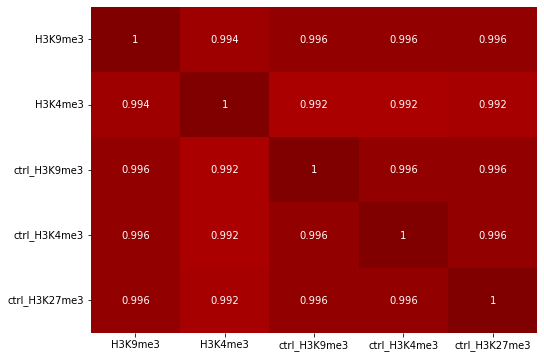

In [ ]:
corrs = np.corrcoef(df.iloc[:,1:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs, vmin=0.9, vmax=1, annot=True, fmt='.3g',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=df.columns[1:], yticklabels=df.columns[1:])

Processed signals

In [ ]:
def KL(x, y):
    return x * np.log10(x / y)

df['KL_H3K4me3_ctrl4'] = KL(df['H3K4me3'], df['ctrl_H3K4me3'])
df['KL_H3K4me3_ctrl9'] = KL(df['H3K4me3'], df['ctrl_H3K9me3'])
df['KL_H3K4me3_ctrl27'] = KL(df['H3K4me3'], df['ctrl_H3K27me3'])
df['KL_H3K9me3_ctrl4'] = KL(df['H3K9me3'], df['ctrl_H3K4me3'])
df['KL_H3K9me3_ctrl9'] = KL(df['H3K9me3'], df['ctrl_H3K9me3'])
df['KL_H3K9me3_ctrl27'] = KL(df['H3K9me3'], df['ctrl_H3K27me3'])


/home/alex/anaconda3/envs/tf2.5/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(230014, 12)
(230220, 12)


<AxesSubplot:>

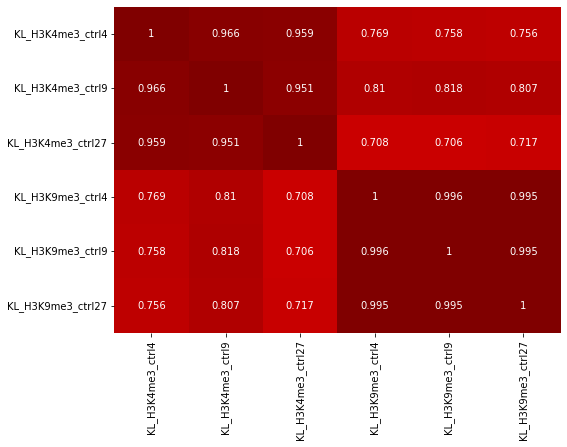

In [ ]:
df2 = df.where(np.isfinite(df)).dropna()
print(df2.shape)
print(df.shape)
corrs_processed = np.corrcoef(df2.iloc[:,6:], rowvar=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corrs_processed, vmin=-1, vmax=1, annot=True, fmt='.3g',
            cmap=plt.cm.get_cmap('seismic'), cbar=False,
            xticklabels=df2.columns[6:], yticklabels=df2.columns[6:])

In [ ]:
log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)

p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
p_vals = np.zeros(len(ip_binned_signal_chr))
for i in range(len(ip_binned_signal_chr)):
    n_binom = ip_binned_signal_chr[i] + ctrl_binned_signal_chr[i]
    k_binom = ip_binned_signal_chr[i]
    if n_binom >= 1:
        res = scipy.stats.binomtest(k_binom, n_binom, p=p_binom, alternative='greater')
        p_vals[i] = res.pvalue
    else:
        p_vals[i] = 1


/tmp/ipykernel_126826/950348216.py:1: RuntimeWarning: invalid value encountered in true_divide
  log_ratio_chr = np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)
/tmp/ipykernel_126826/950348216.py:2: RuntimeWarning: invalid value encountered in true_divide
  KL_chr = ip_binned_signal_chr * np.log10(ip_binned_signal_chr / ctrl_binned_signal_chr)


In [ ]:
from statsmodels.stats import multitest
reject, q_vals, alphaS, alphaB = multitest.multipletests(p_vals, method='fdr_bh')
print(np.sum(reject), "/", len(reject), "rejected")
print(alphaS, alphaB)

1584 / 24895 rejected
2.060383271551558e-06 2.008435428800964e-06


/tmp/ipykernel_126826/85842865.py:7: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(np.arange(bin_start, bin_end, bins), -np.log10(q_vals)[start//bins:end//bins], label='-log(qvalue)', alpha=0.5)
/tmp/ipykernel_126826/85842865.py:11: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])


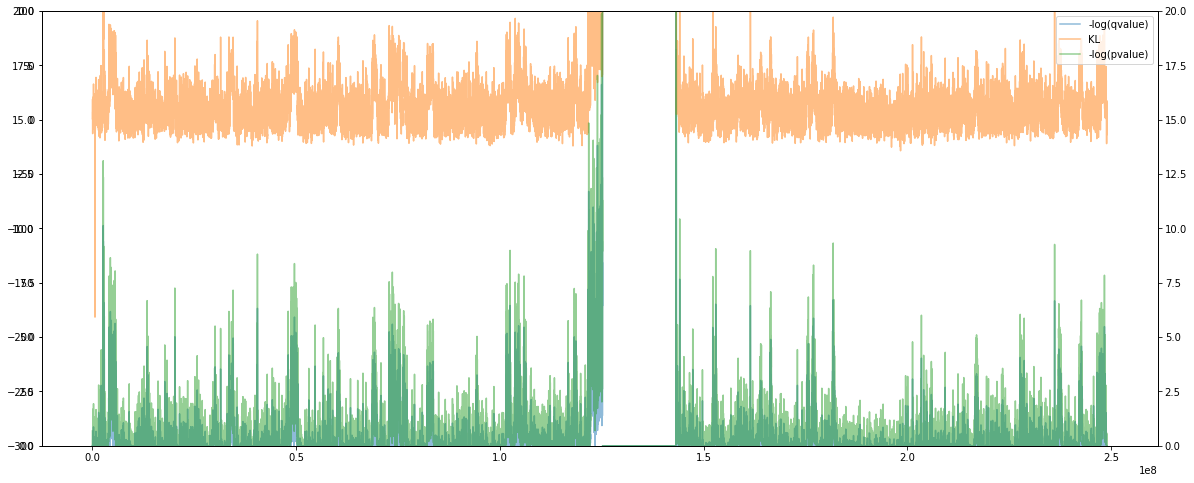

In [ ]:
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(np.arange(bin_start, bin_end, bins), -np.log10(q_vals)[start//bins:end//bins], label='-log(qvalue)', alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(np.arange(bin_start, bin_end, bins), KL_chr[start//bins:end//bins], label='KL', alpha=0.5, color=colors[1])
ax3 = ax2.twinx()
ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])
ax1.set_ylim(bottom=0, top=20)
ax2.set_ylim(bottom=-300, top=100)
ax3.set_ylim(bottom=0, top=20)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3)
plt.show()
plt.close()

Correlation between processed signals

In [ ]:
valid_bins = np.logical_and(np.isfinite(KL_chr), np.isfinite(-np.log10(p_vals)))
print(pearsonr(KL_chr[valid_bins], -np.log10(p_vals)[valid_bins]))
print(pearsonr(KL_chr[valid_bins], log_ratio_chr[valid_bins]))
print(pearsonr(-np.log10(p_vals)[valid_bins], log_ratio_chr[valid_bins]))

(0.979892717680379, 0.0)
(0.47733867495174553, 0.0)
(0.38248846696135685, 0.0)


/tmp/ipykernel_126826/2790222166.py:1: RuntimeWarning: divide by zero encountered in log10
  valid_bins = np.logical_and(np.isfinite(KL_chr), np.isfinite(-np.log10(p_vals)))
/tmp/ipykernel_126826/2790222166.py:2: RuntimeWarning: divide by zero encountered in log10
  print(pearsonr(KL_chr[valid_bins], -np.log10(p_vals)[valid_bins]))
/tmp/ipykernel_126826/2790222166.py:4: RuntimeWarning: divide by zero encountered in log10
  print(pearsonr(-np.log10(p_vals)[valid_bins], log_ratio_chr[valid_bins]))


Plot of processed signals

/tmp/ipykernel_126826/2145195069.py:11: RuntimeWarning: divide by zero encountered in log10
  ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])


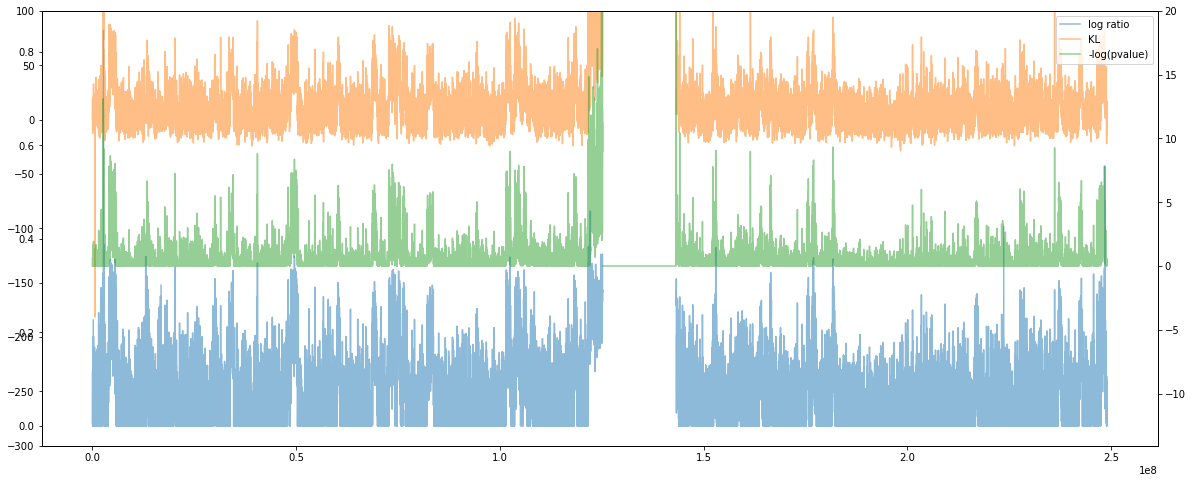

In [ ]:
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(np.arange(bin_start, bin_end, bins), np.maximum(log_ratio_chr[start//bins:end//bins], 0), label='log ratio', alpha=0.5)
ax2 = ax1.twinx()
ax2.plot(np.arange(bin_start, bin_end, bins), KL_chr[start//bins:end//bins], label='KL', alpha=0.5, color=colors[1])
ax3 = ax2.twinx()
ax3.plot(np.arange(bin_start, bin_end, bins), -np.log10(p_vals)[start//bins:end//bins], label='-log(pvalue)', alpha=0.5, color=colors[2])
# ax1.set_ylim(bottom=-1.5)
ax2.set_ylim(bottom=-300, top=100)
ax3.set_ylim(top=20)
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
handles3, labels3 = ax3.get_legend_handles_labels()
plt.legend(handles1 + handles2 + handles3, labels1 + labels2 + labels3)
plt.show()
plt.close()

/tmp/ipykernel_126826/2398279920.py:7: RuntimeWarning: divide by zero encountered in log10
  ax1.scatter(KL_chr[start//bins:end//bins], -np.log10(p_vals)[start//bins:end//bins], label='positions', alpha=0.5)


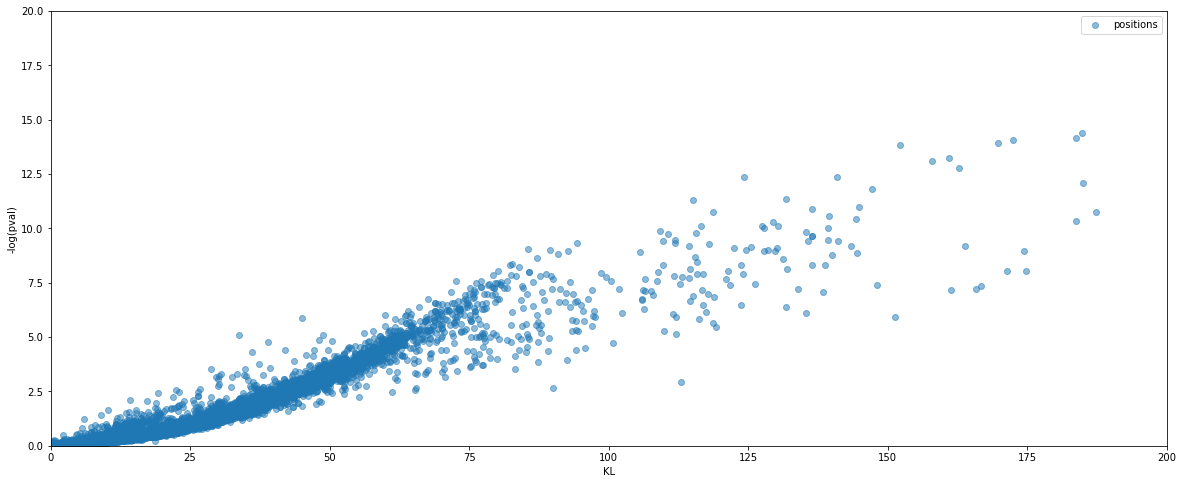

In [ ]:
start = 0 # 30_000_000
end = len(ip_binned_signal_chr)*bins
bin_start = (start // bins) * bins + bins // 2
bin_end = (end // bins) * bins + bins // 2
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.scatter(KL_chr[start//bins:end//bins], -np.log10(p_vals)[start//bins:end//bins], label='positions', alpha=0.5)
ax1.set_xlim(left=0, right=200)
ax1.set_ylim(bottom=0, top=20)
plt.xlabel('KL')
plt.ylabel('-log(pval)')
plt.legend()
plt.show()
plt.close()

Save to csv

In [ ]:
df = pd.DataFrame({'pos': np.arange(0, len(ip_binned_signal_chr)*bins, bins),
                   'ip_binned_signal': ip_binned_signal_chr,
                   'ctrl_binned_signal': ctrl_binned_signal_chr,
                   'log_ratio': log_ratio_chr,
                   'KL': KL_chr,
                   'binom_p_value': p_vals})
df.to_csv(f'{data_dir}/{data}/results/{data}_chr{chr_id}_binned_{bins}.csv')

#### Exact alignment

In [ ]:
ip_signal_chr = utils.exact_alignment_signal_from_coord(ip_coord_chr)
ctrl_signal_chr = utils.exact_alignment_signal_from_coord(ctrl_coord_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))
ip_signal_chr, ctrl_signal_chr = utils.adjust_length(ip_signal_chr, ctrl_signal_chr)
print(len(ip_signal_chr), len(ctrl_signal_chr))

248946395 248946413
248946413 248946413


In [ ]:
ip_postbinned_signal_chr = convolve(ip_signal_chr, np.ones(bins) / bins, mode='same')
ctrl_postbinned_signal_chr = convolve(ctrl_signal_chr, np.ones(bins) / bins, mode='same')

In [ ]:
postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)

# p_binom = len(ip_coord_chr) / (len(ip_coord_chr) + len(ctrl_coord_chr))
# p_vals = np.zeros(len(ip_postbinned_signal_chr))
# for i in range(len(ip_postbinned_signal_chr)):
#     n_binom = ip_postbinned_signal_chr[i] + ctrl_postbinned_signal_chr[i]
#     k_binom = ip_postbinned_signal_chr[i]
#     if n_binom >= 1:
#         res = scipy.stats.binomtest(k_binom, n_binom, p=p_binom, alternative='greater')
#         p_vals[i] = res.pvalue
#     else:
#         p_vals[i] = 1

/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in true_divide
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: divide by zero encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:1: RuntimeWarning: invalid value encountered in log10
  postbinned_log_ratio_chr = np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarning: divide by zero encountered in true_divide
  postbinned_KL_chr = ip_postbinned_signal_chr * np.log10(ip_postbinned_signal_chr / ctrl_postbinned_signal_chr)
/tmp/ipykernel_122611/899252405.py:2: RuntimeWarn

In [ ]:
start = 0 # 122_000_000
end = len(ip_signal_chr)  # 40_000_000
plt.figure(figsize=(20, 8))
ax1 = plt.subplot()
ax1.plot(np.arange(start, end), ip_postbinned_signal_chr[start:end], label='ip', alpha=0.5)
repeats = utils.find_peaks_in_window(all_chr_repeats, start, end)
print(repeats.shape)
rep_height = 1
for id, (rep_start, rep_end, *_) in enumerate(repeats):
    if id == 0:
        ax1.plot([rep_start, rep_end], [rep_height, rep_height], marker = '.', color='red', label='repeats')
    else:
        ax1.plot([rep_start, rep_end], [rep_height, rep_height], marker = '.', color='red')
# plt.plot(np.arange(start, end), ctrl_signal_chr[start:end], label='control', alpha=0.5)
ax1.set_yscale('log')
# handles1, labels1 = ax1.get_legend_handles_labels()
plt.legend(loc="upper right")
plt.show()
plt.close()

(444217, 2)


: 

: 

In [ ]:
ip_binned_signal_chr_old = pd.read_csv(f'{data_dir}/{data}/results/{data}_signal_chr{chr_id}_binned_{bins}.csv')

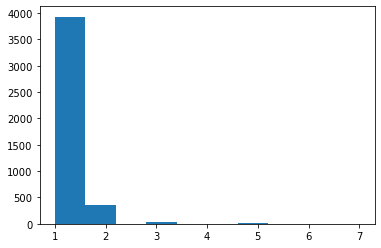

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
diffs = np.array(np.abs(df['binned_signal'] - ip_binned_signal_chr_old['binned_signal']))
nonzeros, = np.nonzero(diffs)
plt.hist(diffs[nonzeros])
plt.show()
plt.close()
diffs[nonzeros]

In [ ]:
import timeit
n = 10_000_000
m = 100_000_000
coord = np.random.randint(0, m, size=2*n, dtype=int).reshape(-1, 2)
# print(coord)

In [ ]:
%%timeit
signal = utils.exact_alignment_signal_from_coord(coord)

1.33 s ± 47.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
binned_signal = utils.binned_alignment_signal_from_coord(coord, bins=1000)

794 ms ± 12.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
binned_signal = utils.binned_alignment_signal_from_coord(coord, bins=1)

1.23 s ± 90.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
